# Ensemble techniques

#### Importing relevant libraries

In [75]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, confusion_matrix
from os import system
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
import graphviz

### 1. Exploratory data quality report

In [44]:
# Importing data
data=pd.read_csv('../Data/bank-full.csv')

# a. Univariate analysis
print(data.shape) # Number of rows and columns in the dataframe
print(data.isnull().values.any()) # To check for null values in the dataframe
print(data.info()) # To check the data type of the columns of the dataframe
print(data.describe().transpose()) # To review the statistical summary of the dataframe
data.head()

(45211, 17)
False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  Target     45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB
None
            count         mean          std     min    25%    50%     75%  \

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


#### Insight: The object type columns needs to be converted to categorical type variables

In [45]:
# converting object type to categorical variables
for c in data.columns:
    if data[c].dtype=='object':
        data[c]=pd.Categorical(data[c])
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [46]:
# printing value counts of converted columns
print(data.job.value_counts()) # No particular order: One hot encoding
print(data.marital.value_counts())
print(data.education.value_counts())
print(data.default.value_counts())
print(data.housing.value_counts())
print(data.loan.value_counts())
print(data.contact.value_counts()) # No particular order: One hot encoding 
print(data.month.value_counts())
print(data.poutcome.value_counts())
print(data.Target.value_counts())

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64
no     44396
yes      815
Name: default, dtype: int64
yes    25130
no     20081
Name: housing, dtype: int64
no     37967
yes     7244
Name: loan, dtype: int64
cellular     29285
unknown      13020
telephone     2906
Name: contact, dtype: int64
may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64
unknown    36959
failure     4901
other       1840
success     1511
Name: poutcome, dtype: int64
n

In [47]:
# Constructing array for restructuring
rstruct={'marital':{'single':0, 'married':1, 'divorced':2}, 'education':{'unknown':-1,'primary':0,'secondary':1,'tertiary':2}, 'default':{'no':0, 'yes':1}, 'housing':{'no':0, 'yes':1}, 'loan':{'no':0, 'yes':1}, 'Target':{'no':0, 'yes':1}, 'poutcome':{'unknown':-1,'failure':0, 'success':1, 'other':2}, 'month':{'jan':1,'feb':2,'mar':3,'apr':4,'may':5,'jun':6,'jul':7,'aug':8,'sep':9,'oct':10,'nov':11,'dec':12}}
#rstruct={"marital":{"single":0, "married":1, "divorced":2}}
onehotcol=["job","contact"]

# Replacing bank data with new structure
data=data.replace(rstruct)
data=pd.get_dummies(data, columns=onehotcol)

In [13]:
# Visualizing modified dataframe 
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                45211 non-null  int64
 1   marital            45211 non-null  int64
 2   education          45211 non-null  int64
 3   default            45211 non-null  int64
 4   balance            45211 non-null  int64
 5   housing            45211 non-null  int64
 6   loan               45211 non-null  int64
 7   day                45211 non-null  int64
 8   month              45211 non-null  int64
 9   duration           45211 non-null  int64
 10  campaign           45211 non-null  int64
 11  pdays              45211 non-null  int64
 12  previous           45211 non-null  int64
 13  poutcome           45211 non-null  int64
 14  Target             45211 non-null  int64
 15  job_admin.         45211 non-null  uint8
 16  job_blue-collar    45211 non-null  uint8
 17  job_entrepre

,age,marital,education,default,balance,housing,loan,day,month,duration,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,contact_cellular,contact_telephone,contact_unknown
0,58,1,2,0,2143,1,0,5,5,261,...,0,0,0,0,0,0,0,0,0,1
1,44,0,1,0,29,1,0,5,5,151,...,0,0,0,0,1,0,0,0,0,1
2,33,1,1,0,2,1,1,5,5,76,...,0,0,0,0,0,0,0,0,0,1
3,47,1,-1,0,1506,1,0,5,5,92,...,0,0,0,0,0,0,0,0,0,1
4,33,0,-1,0,1,0,0,5,5,198,...,0,0,0,0,0,0,1,0,0,1


Univariate analysis



array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'marital'}>],
       [<AxesSubplot:title={'center':'education'}>,
        <AxesSubplot:title={'center':'default'}>],
       [<AxesSubplot:title={'center':'balance'}>,
        <AxesSubplot:title={'center':'housing'}>],
       [<AxesSubplot:title={'center':'loan'}>,
        <AxesSubplot:title={'center':'day'}>],
       [<AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':'duration'}>],
       [<AxesSubplot:title={'center':'campaign'}>,
        <AxesSubplot:title={'center':'pdays'}>],
       [<AxesSubplot:title={'center':'previous'}>,
        <AxesSubplot:title={'center':'poutcome'}>],
       [<AxesSubplot:title={'center':'Target'}>,
        <AxesSubplot:title={'center':'job_admin.'}>],
       [<AxesSubplot:title={'center':'job_blue-collar'}>,
        <AxesSubplot:title={'center':'job_entrepreneur'}>],
       [<AxesSubplot:title={'center':'job_housemaid'}>,
        <AxesSubplot:titl

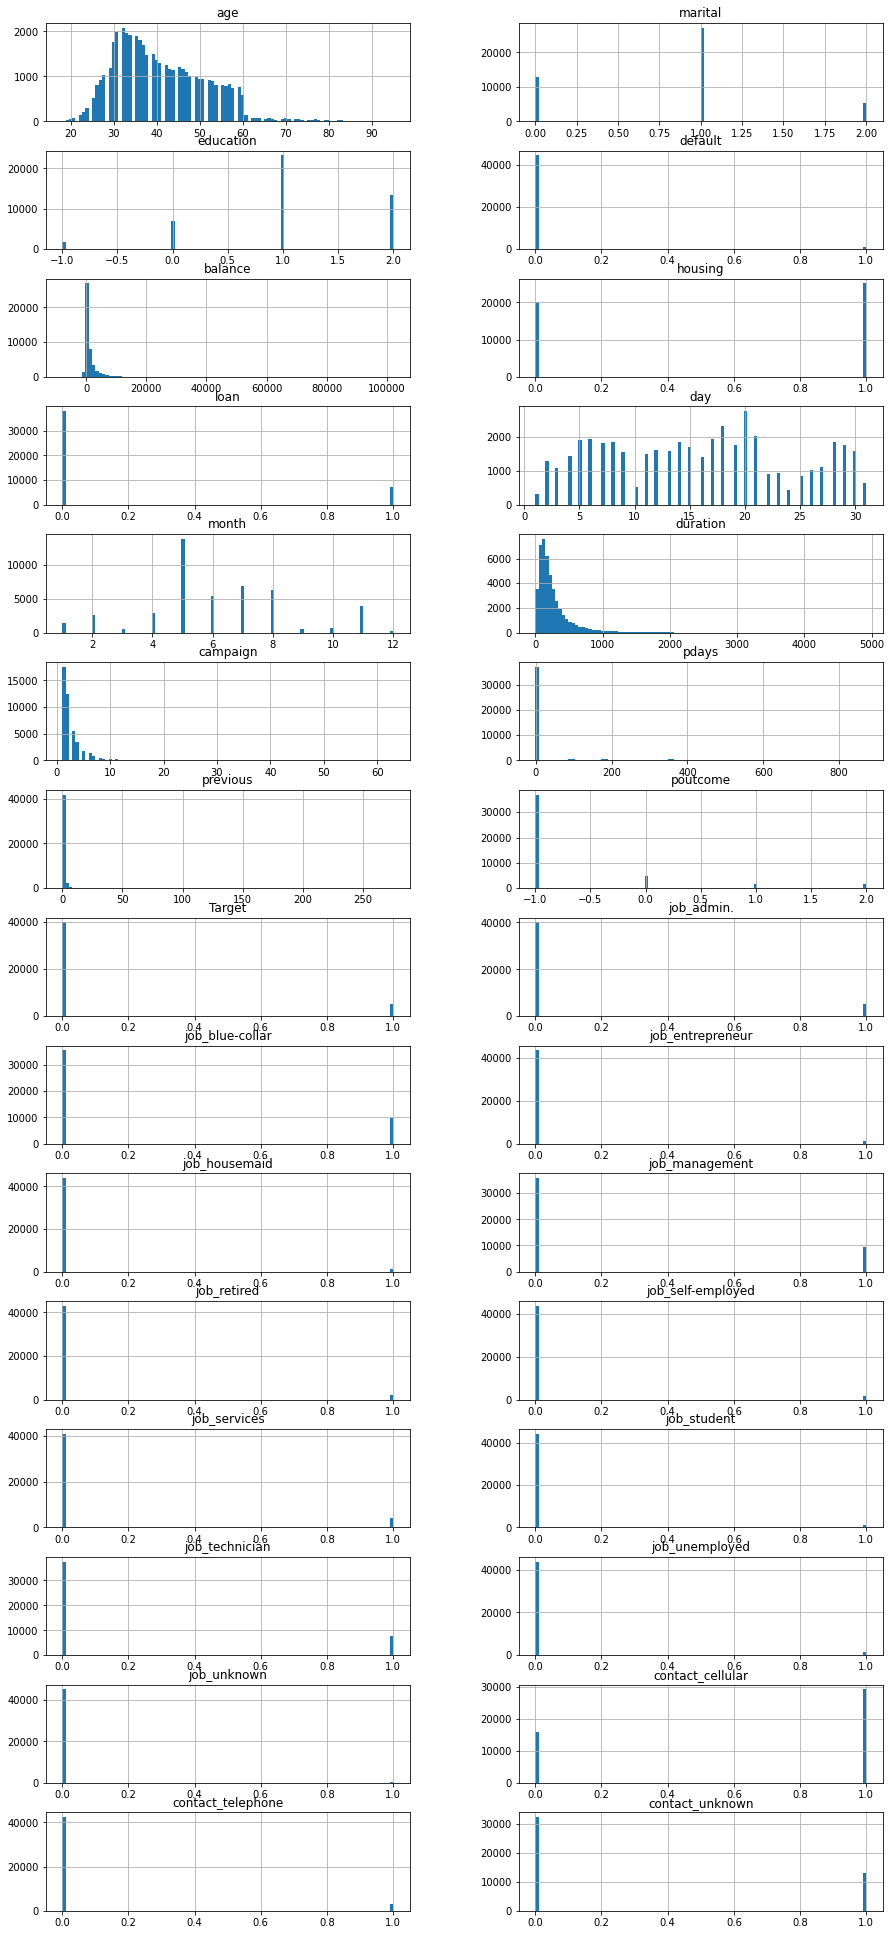

In [51]:
# Univariate analysis
print('Univariate analysis\n')
#columns2stay = ['age', 'marital', 'education', 'default', 'balance', 'duration','campaign','pdays', 'poutcome','Target'] # Categorical columns
#columns2drop = ['day', 'month']
#data2 = data.drop(columns2drop,1) 
data.hist(stacked=False, bins=100, figsize=(15,70), layout=(30,2))

Bivariate analysis



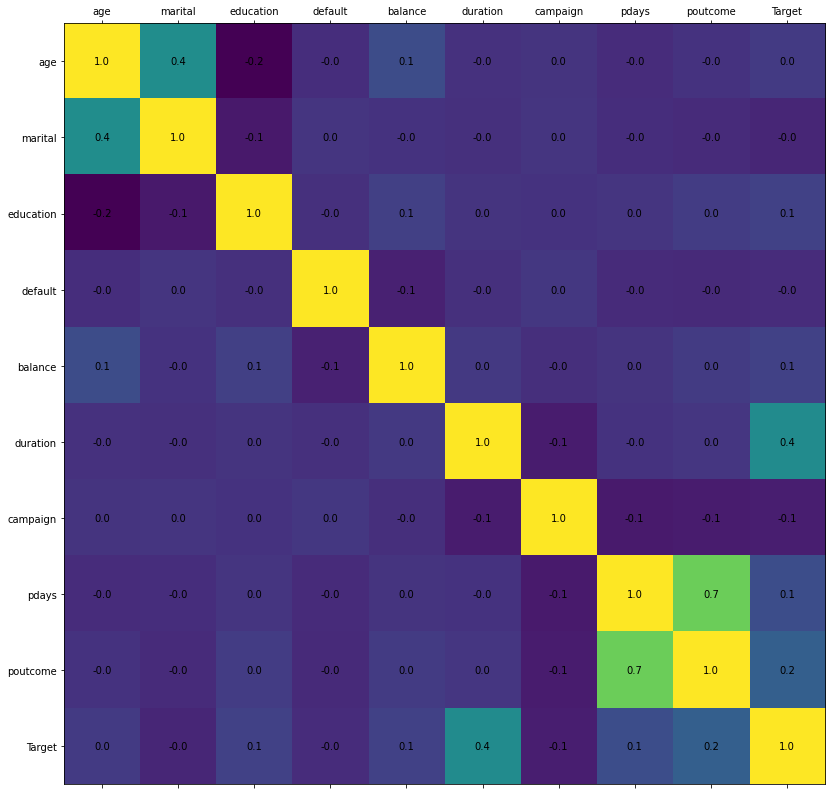

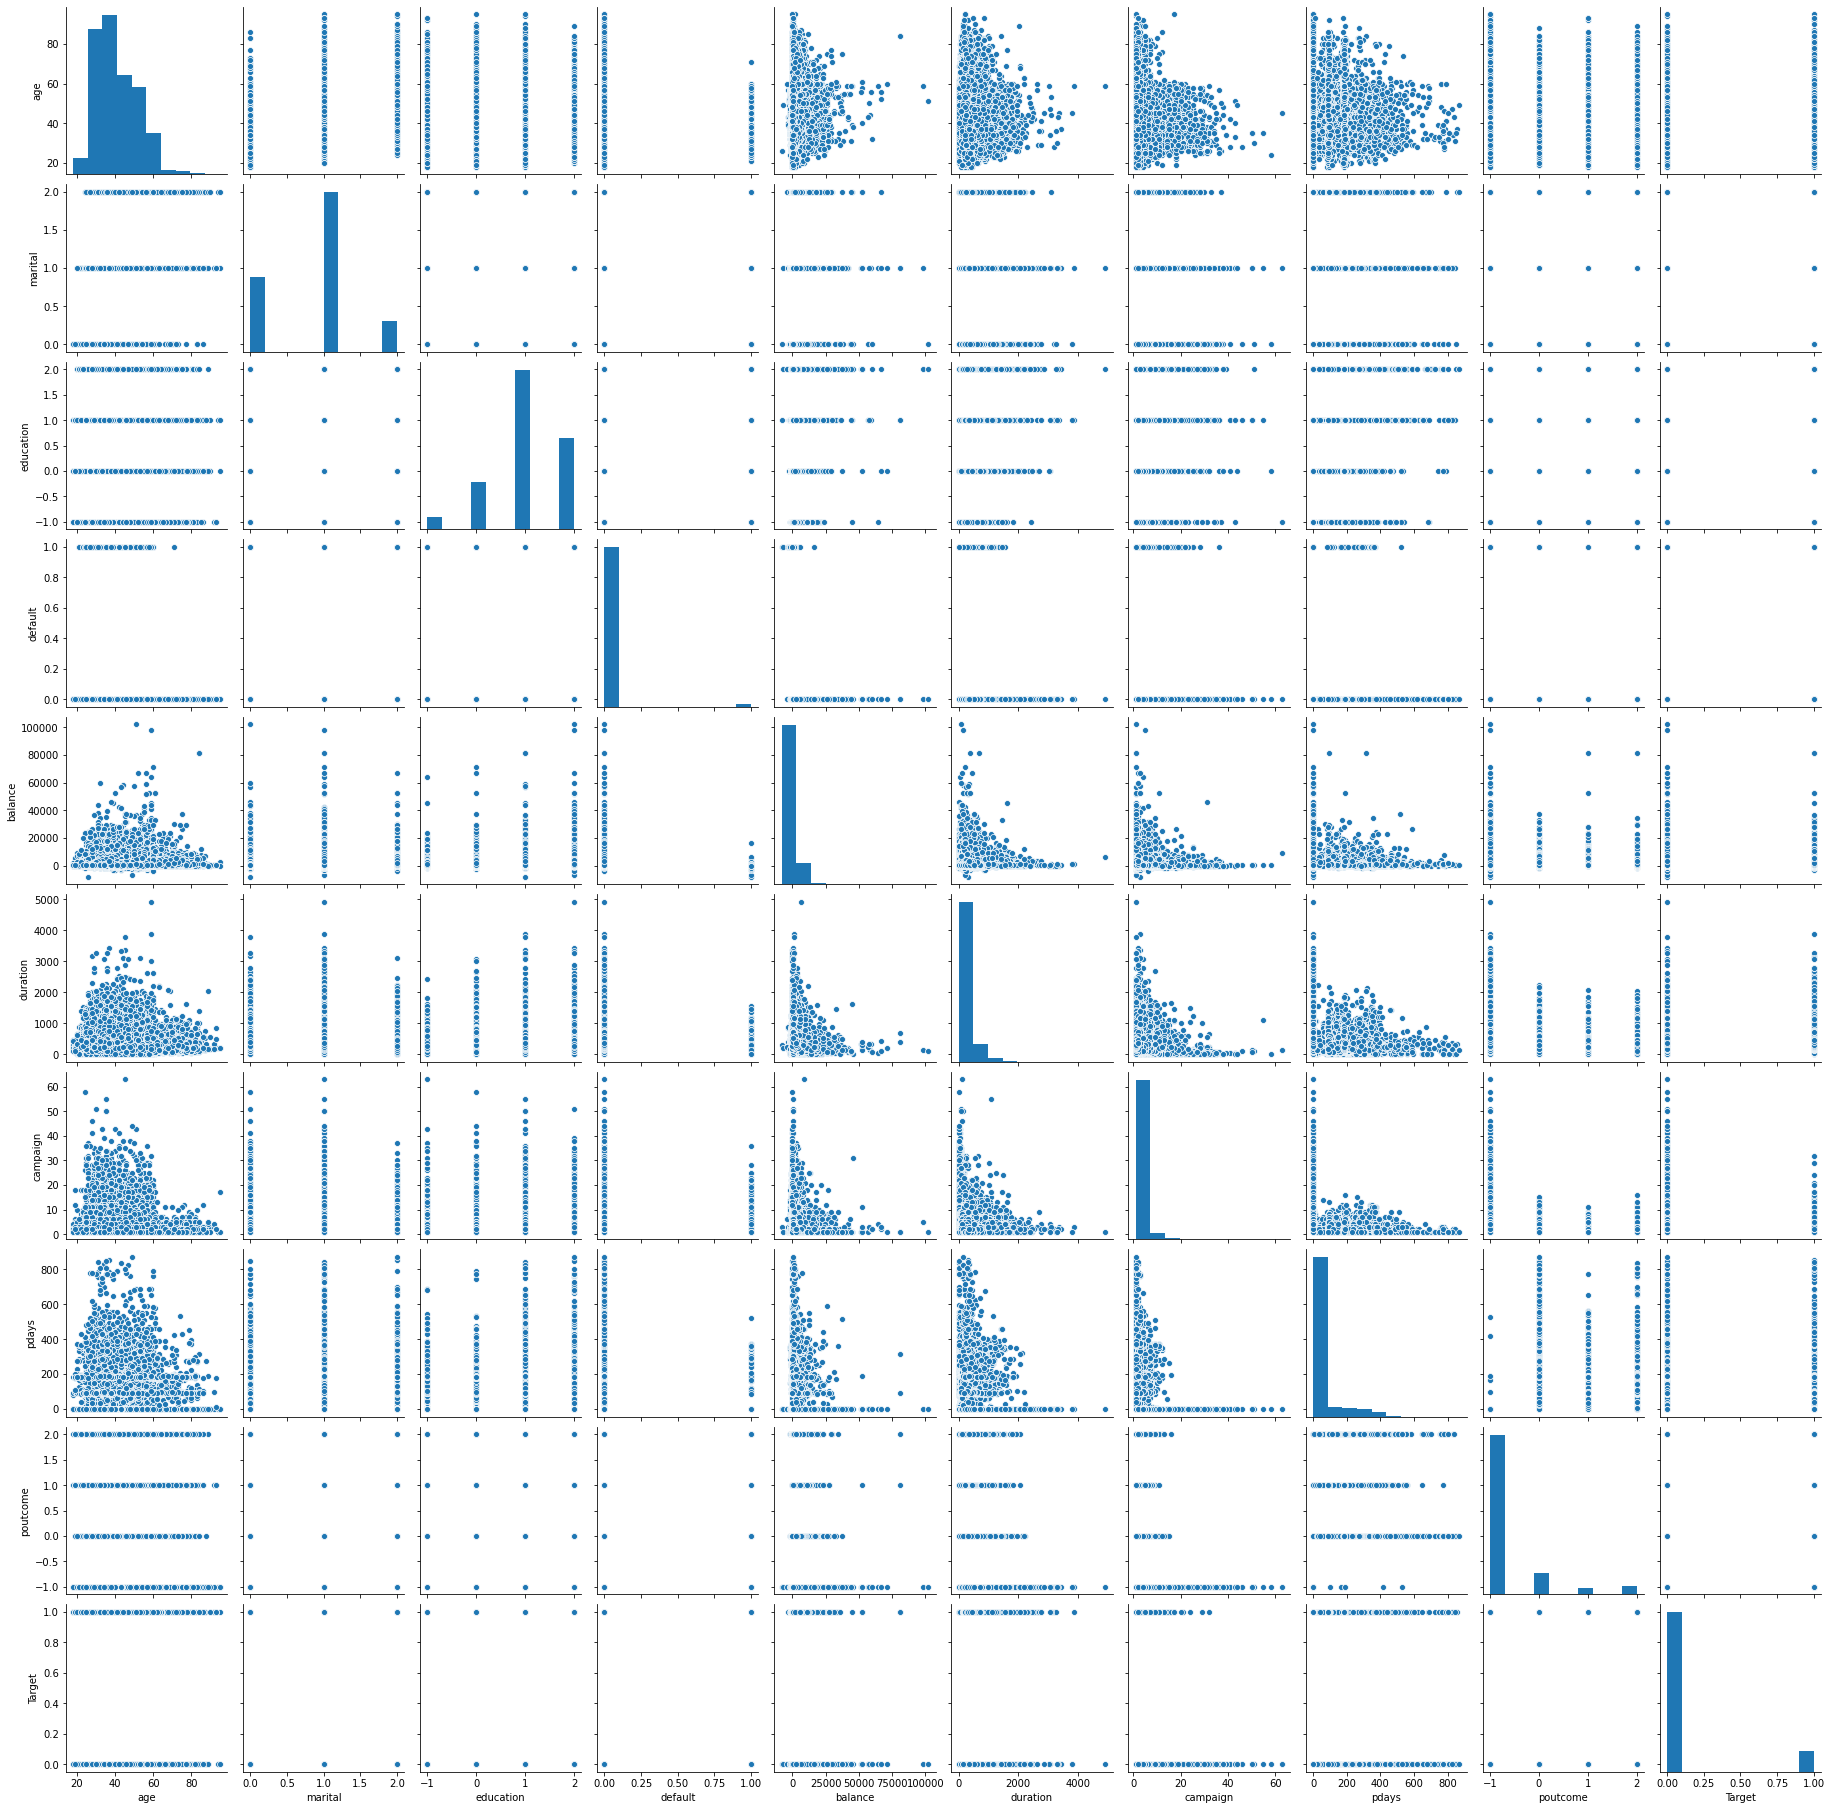

In [15]:
# Bivariate analysis
print('Bivariate analysis\n')
corr = data2.corr()
fig, ax = plt.subplots(figsize=(14, 14))
ax.matshow(corr)
plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)
for (i, j), z in np.ndenumerate(corr):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')
sns.pairplot(data2)

#### Insight: No two features are highly correlated. poutcome and pdays seem to be correlated only because unknown has been categorized as -1 which matches with that of -1 of pdays.

### 2. Preparing data for analytics

#### Splitting data

In [66]:
X = data.drop('Target',axis=1)
Y = data['Target']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=7)
print(x_train.head())
print(data2['Target'].value_counts())
print("{0:0.2f}% data is in training set".format((len(x_train)/len(data.index)) * 100))
print("{0:0.2f}% data is in test set".format((len(x_test)/len(data.index)) * 100))

       age  marital  education  default  balance  housing  loan  day  month  \
35272   39        0          2        0     4239        1     0    7      5   
10705   44        1          2        0      647        0     0   16      6   
43536   46        2          0        0      429        1     0   26      4   
6960    55        1          0        0       81        1     0   28      5   
41892   28        1          1        0      172        1     0   19     10   

       duration  ...  job_retired  job_self-employed  job_services  \
35272        40  ...            0                  0             0   
10705       226  ...            0                  0             0   
43536       465  ...            0                  0             0   
6960        172  ...            0                  0             0   
41892       123  ...            0                  0             0   

       job_student  job_technician  job_unemployed  job_unknown  \
35272            0               0   

#### Training and testing the data

In [104]:
model_entropy=DecisionTreeClassifier(criterion='gini')
model_entropy.fit(x_train, y_train)
model_entropy.score(x_train, y_train)  # performance on train data

1.0

In [105]:
model_entropy.score(x_test, y_test)  # performance on test data

0.8790179887938662

#### Visualizing the decision tree

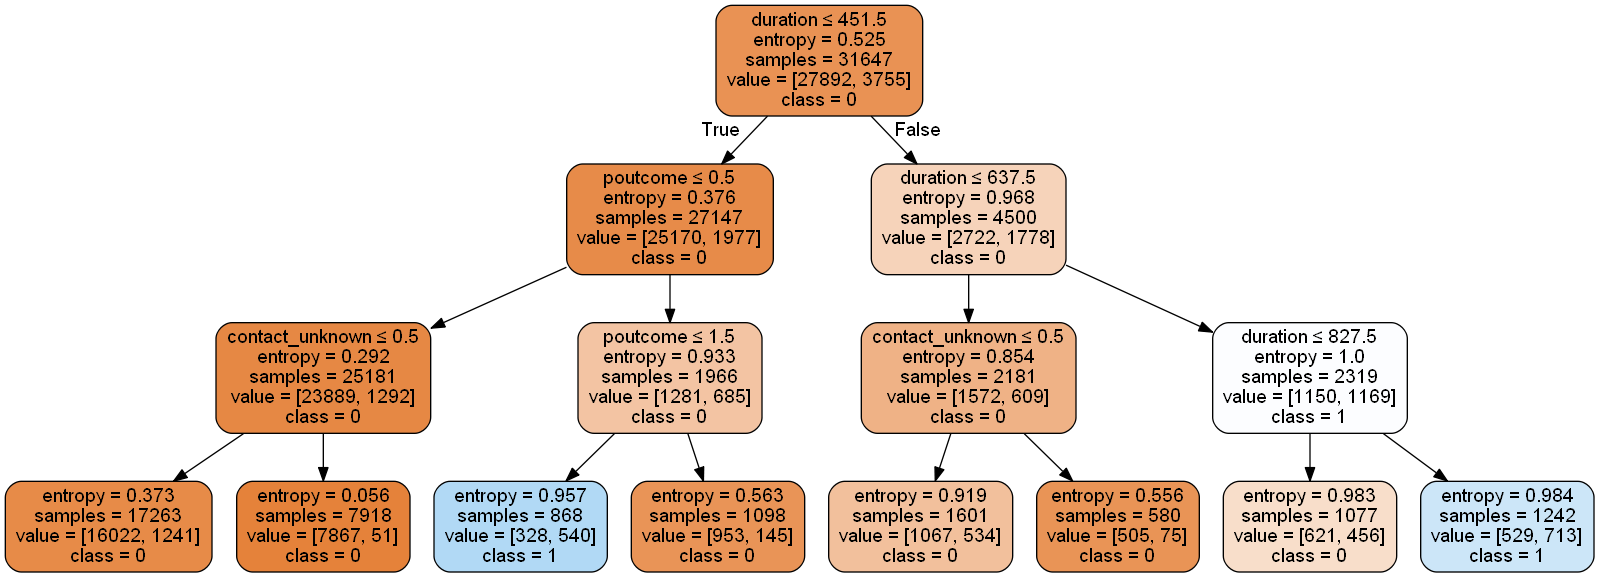

In [79]:
dt_pruned = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth=3, min_samples_leaf=5)
dt_pruned.fit(x_train, y_train)

xvar = data.drop('Target', axis=1)
feature_cols = xvar.columns

dot_data = StringIO()
export_graphviz(dt_pruned, out_file=dot_data, filled=True, rounded=True, special_characters=True,feature_names = feature_cols,class_names=['0','1','2'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('bank.png')
Image(graph.create_png())

#### Quality of pruned decision tree

In [88]:
predict_pruned = dt_pruned.predict(x_test)
predict_pruned_train = dt_pruned.predict(x_train)
print(accuracy_score(y_test,predict_pruned))
print(accuracy_score(y_train,predict_pruned_train))
acc_dt = accuracy_score(y_test, predict_pruned)
'''Storing the decision tree accuracy data in a dataframe'''
accresdf = pd.DataFrame({'Method':['Decision Tree'], 'Accuracy':[acc_dt]})
accresdf = accresdf[['Method','Accuracy']]
accresdf

0.8986287230905338
0.8938603975100325


,Method,Accuracy
0,Decision Tree,0.898629


In [81]:
# Calculating feature importance using predefined function
ft_importance = dt_pruned.tree_.compute_feature_importances(normalize=False)
ft_imp_dict = dict(zip(feature_cols, dt_pruned.feature_importances_))
ft_imp = pd.DataFrame.from_dict(ft_imp_dict, orient='index')
ft_imp.sort_values(by=0, ascending=False) # Sorting in descending order of importance

,0
duration,0.536721
poutcome,0.335623
contact_unknown,0.127656
job_entrepreneur,0.000000
contact_telephone,0.000000
contact_cellular,0.000000
job_unknown,0.000000
job_unemployed,0.000000
job_technician,0.000000
job_student,0.000000


#### *Insight*: The features duration, poutcome and contact_unknown are the only ones which impact the Target variable (whether the target subscribes the term deposit or not)